# Project: Gapminder World - Revised & Animated

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This work is inspired by [this exciting talk](https://youtu.be/FACK2knC08E) of Hans Rosling from [Gapminder](https://www.gapminder.org), showing the *"Gapminder World"* which illustrates clearly the correlation between the income of the people of a country and their life expectancy. My challenge is to rebuild and possibly extend this illustration based on the raw data provided by the Gapminder Foundation.

![Correlation of GDP/income versus life expectancy Gapminder](Gapminder_World_2012.png)

Apparently, there are some outliers, i.e. some countries people life expectancy is relatively low although the people having a quite decent average income (GDP per capita). On the other hand, some countries people will likely have a long life while being relatively poor compared to the rest of the world. Of course, there are certainly many more indicators that might have an impact to the health of a society.

### Question 1: What is the impact of inequality?
While the *"Gapminder World"* points out the correlation of peoples income and life expectancy, it is not showing the fact that the inequality of income within the countries might be very different. Hence, the inequality within the countries might in turn correlate with the average life expactancy of their citizens.

### Question 2: How is the per capita income distributed across the people?
The distibution of the income of the people of a population can be illustrated through bins of a certain range of income and the number of people having it like in the figure below.

![Distribution of annual household income in the United States](Distribution_of_Annual_Household_Income_in_the_United_States_2010.png)

The beauty of such an illustration is that it might fit into the *"Gapminder World"* diagram, rather than bubbles showing just the size of a population.

### Used Data
- **GDP per capita** based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar 
- **Life expectancy at birth** The average number of years a newborn child would live if current mortality patterns were to stay the same.
- **Income share held by**... Percentage share of income or consumption is the share that accrues to subgroups of population indicated by deciles or quintiles.
- **Total population**
- **Some other indicators** featuring time and value can be merged easily to the choosen shape of the dataframe

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib.collections import PatchCollection

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import sqlite3
from IPython.display import display, HTML, Image

print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


<a id='wrangling'></a>
## Data Wrangling

### General Properties
All Gapminder data is numerical time series data. Each indicator is stored in a single file. The data is provided in Microsoft Excel format. Reading all files that er stored in a certain directory is preferred rather than writing path and filenames to the Jupyter notebook.

In [2]:
from pathlib import Path

DATA_EXTENSIONS = '.xlsx'

def excel_contents(p_name):
    ret = []
    for root, dirs, files in os.walk(p_name):
        #print('Found directory: %s' % root)
        for filename in files:
            if filename.endswith('.xlsx'):
                #print(filename)
                ret.append(root + '/' + filename)
    return ret


In [3]:
# Path to the data
data_path = os.path.abspath(os.path.join('Gapminder/data'))
# print("data_path = %s" % (data_path))

In [4]:
# Get a list of all excel files in the folder
list_of_excel_files = excel_contents(data_path)

Excel files are ugly. All data found is stored into a SQLite database.
Let the country be the column and the year be the row.

In [5]:
import warnings
warnings.filterwarnings('ignore') # Switch of UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.

MIN_NUMBER_OF_ENTRIES = 1 # Drop all countries that have less than MIN_NUMBER_OF_ENTRIES elements
connlite3 = None
connlite3 = sqlite3.connect(data_path + "/gapminder_extract.sqlite3")
for xls_file in list_of_excel_files:
    pdf = pd.read_excel(xls_file)
    table_name = pdf.columns[0]
    # print(table_name)
    pdf = pdf.rename(columns = {table_name:'Country'}) # .set_index("Country")
    pdf.drop_duplicates(subset=['Country'], keep=False, inplace=True) # Some datasets are corrupt and have duplicate countries or named "nan"
    pdfT = pdf.T.rename(columns=pdf["Country"]).drop('Country') # Make the countries the new column names and then drop the row that contains the countries
    pdfT.dropna(axis=1, thresh=MIN_NUMBER_OF_ENTRIES, inplace=True)
    pdfT.to_sql(table_name, connlite3, if_exists="replace") # Transpose to make the time the new index and the country the cloumn
connlite3.close()
warnings.filterwarnings('once')

In [6]:
def read_these_tables_from_sql(t_names, conn):
    tables = {}
    for table_name in t_names:
        querystr = "SELECT * FROM `" + table_name + "`"
        tables.update( {table_name: pd.read_sql_query(querystr, conn)} )#.set_index('index')} )
    return tables

def melt_tables(dict_of_tables):
    """
    pd.melt() each table given in dict_of_tables and create a general DataFrame through pd.merge() in the second step.
    """
    result = pd.DataFrame()
    for key, table in dict_of_tables.items(): #iteritems in Python 2
        #id_vars = ["index"] # can be more
        table['index'] = table['index'].astype('int64') # Because some index were stored as str. TODO correct this in read_these_tables_from_sql
        print(key)
        #print(table.info())        
        df = pd.melt(table, id_vars=["index"], var_name="Country", value_name=key)
        #df = pd.melt(table, var_name="Country", value_name=key)
        if (not result.empty):
            result = pd.merge(result, df, how='outer', on=["index", "Country"], validate="one_to_one")
            # result = pd.merge(result, df, how='outer', on=["Country"])
            # From Pandas docs: Users can use the validate argument to automatically check whether there are unexpected duplicates in their merge keys. Key uniqueness is checked before merge operations and so should protect against memory overflows. Checking key uniqueness is also a good way to ensure user data structures are as expected.
        else:
            result = df
    return result
        


In [7]:
def divide_by_population(df_2_divide, list_of_indicators):
    for indicator in list_of_indicators:
        df_2_divide[indicator] = df_2_divide[indicator].div( df_2_divide["Total population"] / 100000 )
    return df_2_divide


def income_rebinning(income_dist, num_steps=100, drop_transformed=True):
    """
    The income distributions per country, as found in the datasets from Gapminder (and World Bank)
    have inequal bin sizes.
    This function
    TODO: num_steps (num_bins) should add up to 100% for every value.
    """
    dist_cols = income_dist.columns[ income_dist.columns.isin((np.arange(11)*10).astype(str)) ]
    share_vals = income_dist.loc[:, dist_cols]
    #X = pd.Series(share_vals.columns.astype('float')) # Percentage of population
    ser = pd.Series(share_vals.iloc[0,:]) #.sort_values(ascending=True)
    ser.index = ser.index.values.astype(float)
    ser.sort_index(ascending=True, inplace=True)
    X = pd.Series([0]+list(ser.index.values.astype(float)))
    Y = pd.Series([0]+list(ser.values))
    Y_div_dX = Y.divide(X.diff())#.shift(-1)
    #dY_dX[0] = 0.0 # Remove NaN due to diff
    #print("Y:")
    #print(Y)
    #print("X:")
    #print(X)
    #print("Y_div_dX:")
    Y_div_dX.iloc[0] = 0
    #print(Y_div_dX)
    Y_div_dX_interp = scipy.interpolate.interp1d( X, Y_div_dX, kind='linear', fill_value="extrapolate" )
    take_these_samples = np.arange(num_steps)*100/num_steps
    X_interp = np.zeros((int(num_steps), 1))
    Y_interp = np.zeros((int(num_steps), 1))

    k = 0
    while k < num_steps:
        #print(take_these_samples[k])
        # Store the results to plot later
        X_interp[k] = take_these_samples[k]#r.t
        #Y_interp[k] = Y_div_dX_interp(take_these_samples[k]+100/(2*num_steps))*100/num_steps # sample in the middle
        # + 5 To sample in the middle and do some "adequate" extrapolation
        Y_interp[k] = Y_div_dX_interp(take_these_samples[k]+5)*100/num_steps
        k += 1
    
    #plt.subplot(2,1,1)
    #plt.plot(X, Y, 'o', X_interp, Y_interp, 'x')
    #plt.subplot(2,1,2)
    #plt.plot(X, Y_div_dX.shift(-1),'o')
    #plt.show()

    #print(dY_dX)
    income_dist_new = pd.DataFrame(index=income_dist.index,\
                                   columns=['IncomeShare_' + s for s in X_interp.T.astype('str').tolist()[0]],\
                                   data=Y_interp.T
                                  )
    if drop_transformed:
        income_dist = income_dist.drop(dist_cols, axis=1)
    for c in income_dist_new.columns:
        income_dist.insert(len(income_dist.columns), c, income_dist_new[c])
    #income_dist.loc[:, income_dist_new.columns] = income_dist_new
    return income_dist


#pop= np.arange(0,10)*10
#income_share_interp = interp1d( pop_bins, share_vals.loc["Argentina"], kind='slinear', fill_value="extrapolate" )

table_names =  [\
                "Life expectancy",\
                "Total population",\
                "GDP per capita"]#,\
#                "Total GDP, PPP",\
#                "GNI per capita, Atlas method (current US$)",\
#                "GNI per capita (constant 2000 US$)",\
#                "GNI per capita, PPP (current international $)",\
#                "Total GNI, PPP (current international $)",\
#                "GINI index"]
additional_table_names =  [\
                #"Under five mortality",\
                #"CO2 per capita",\
                #"Working hours per week",\
                "Per capita government expenditure on health (PPP int. $)",\
                #"Military expenditure (% of GDP)",\
                #"War, age-adjusted mortality due to",\
                #"Arms exports (constant 1990 US$)",\
                #"Arms imports (constant 1990 US$)",\
                "Physicians per 1000 people",\
                #"Prevalence of current tobacco use among adults (>=15 years) (%) both sexes",\
                #"Lung Female Mortality",\
                #"Lung Male Mortality",\
                #"average alcohol consumption, adult (15+) per capita consumption in litres pure alcohol",\
                #"Liver Female Mortality",\
                #"Liver Male Mortality",\
                #"TB mortality, all forms (per year)",\
                #"Estimated new HIV infections (All ages)",\
                "Annual number of AIDS deaths",\
                #"Maternal Deaths",\
                #"Adult (15+) literacy rate (%). Female",\
                #"Adult (15+) literacy rate (%). Male",\
                #"Children month 1-59, all cause death",\
                ]#,\

additional_table_names_absolute = [\
                #"Children month 1-59, all cause death",\
                #"Maternal Deaths",\
                #"TB mortality, all forms (per year)",\
                #"Estimated new HIV infections (All ages)",\
                "Annual number of AIDS deaths",\
                ]

table_names_income =  [\
                "Income share held by highest 10%",\
                "Income share held by highest 20%",\
                "Income share held by second 20%",\
                "Income share held by third 20%",\
                "Income share held by fourth 20%",\
                "Income share held by lowest 20%",\
                "Income share held by lowest 10%"]

conn = sqlite3.connect(data_path + "/gapminder_extract.sqlite3")
querystr = "SELECT name FROM sqlite_master WHERE type='table'"
list_of_tables_in_db = pd.read_sql_query(querystr, conn)
# HTML(list_of_tables_in_db.to_html())

tables_per_indicator = read_these_tables_from_sql(table_names, conn)
print("pd.melt() these tables:")
indicators = melt_tables(tables_per_indicator)#.dropna(how='all')
additional_indicators = melt_tables(read_these_tables_from_sql(additional_table_names, conn))
# The bins are always the value to the next
income_raw = read_these_tables_from_sql(table_names_income, conn)
income_dic = {}
income_dic.update( {'10': income_raw["Income share held by lowest 10%"]} )
income_dic.update( {'20': \
                   (income_raw["Income share held by lowest 20%"].set_index("index")\
                    - income_raw["Income share held by lowest 10%"].set_index("index")).reset_index()} )
income_dic.update( {'40': income_raw["Income share held by second 20%"]} )
income_dic.update( {'60': income_raw["Income share held by third 20%"]} )
income_dic.update( {'80': income_raw["Income share held by fourth 20%"]} )
income_dic.update( {'90': \
                   (income_raw["Income share held by highest 20%"].set_index("index")\
                    - income_raw["Income share held by highest 10%"].set_index("index")).reset_index()} )
income_dic.update( {'100': income_raw["Income share held by highest 10%"]} )
income_distribution = melt_tables(income_dic).dropna(how='any')
#mysum = income_distribution[['0','10','20','40','60','80','90']].dropna().sum(axis=1)
conn.close()


test_group = income_distribution.groupby(['Country','index']).get_group( ('United States',2000) )
test = income_rebinning(test_group, num_steps=100)

pd.melt() these tables:
Total population
GDP per capita
Life expectancy
Annual number of AIDS deaths
Per capita government expenditure on health (PPP int. $)
Physicians per 1000 people
90
60
20
100
40
10
80


The data is provided per indicator, e.g. the *Life expectancy*, as table of countries and year (index).

In [8]:
HTML(tables_per_indicator['Life expectancy'].head(3).to_html())

I did take the advice of looking into ways of reshaping the data so that it is tidy, especially for comparisons across indicators. After joining the data together, the columns might look like:
{Country, Year, Indicator 1 Value, Indicator 2 Value, ... }

Hence, several indicators are melt and merged into one DataFrame, resulting in a shape like this:

In [9]:
HTML(indicators.head(3).to_html())

The data provided on *Income share held by...* contains the percentage share of income of groups (bins) of a population.
The column name "10" references the poorest 10% whereas the column name "100" references the richest 10% of a population. "90" are the second richest group of the population, but "80" are the 20% following the second richest 10% of the population...
Obviously, the groups are not equally sized. This is not convenient for the further analysis. Therfore, the data will be interpolated and transformed to equally sized bins in the next step.

In [10]:
HTML(income_distribution.head(5).to_html())

Accordingly, the interpolated *income share* of groups of each 1% of a population has the following shape for example for the United States:

In [11]:
HTML(test.to_html())

In [12]:
# test.sum(axis=1)

In [13]:
def income_bin_swap(income_dist, bin_size=0.25, max_factor=10, agg_factor=3.0, drop_transformed=True):
    """
    Transformation of the income share of of equally sized bins of people of a population
    to a percentage of people that are a certain range of the GDP.
    
    Usage:
        income_bin_swap(income_dist, bin_size=0.25, max_factor=10, agg_factor=5.0, drop_transformed=True)
        bin_size: bin size as fraction of GDP
        max_factor: weahlth up to this factor of the GDP to be considered.
        agg_factor: aggregate from this factor of wealth
        drop_transformed: drop the source data from which these results are calculated from
    """
    num_steps = int(agg_factor/bin_size +1)
    dist_cols = [x for x in income_dist.columns if x.startswith('IncomeShare_')]
    share_vals = income_dist.loc[:,dist_cols]
    ser = pd.Series(share_vals.iloc[0,:])
    X = np.array([item.strip('IncomeShare_') for item in ser.index.values]).astype('float')
    Y = pd.Series(ser.values)

    income_dist_interp1d = scipy.interpolate.interp1d( X, Y, kind='quadratic', fill_value="extrapolate" )

    #take_these_samples = np.arange(num_steps)*100/num_steps
    X_interp = np.zeros((int(num_steps), 1))
    for pos in range(len(X_interp)):
        X_interp[pos] = pos*bin_size
    Y_interp = np.zeros((int(num_steps), 1))
    
    k = 1
    yk = 1
    last_sol = 0.0
    max_income_bin = income_dist_interp1d(100)
    while (k-1)*bin_size < max_income_bin:
        # Store the results to plot later
        x0=1.0
        sol = scipy.optimize.fsolve(lambda x: income_dist_interp1d(x) - k*bin_size, x0)
        bin_val = sol - last_sol # income_dist_interp1d(take_these_samples[k])#*100/num_steps
        last_sol = sol
        k += 1
        if k*bin_size < agg_factor:
            #X_interp[yk] = bin_size*k
            Y_interp[yk] = bin_val
            yk += 1 # else aggregate
        else:
            Y_interp[yk] += bin_val
    
    #plt.subplot(2,1,1)
    #plt.plot(X, income_dist_interp1d(X), 'o')
    #plt.subplot(2,1,2)
    #plt.plot(X_interp, Y_interp,'o')
    #plt.show()
    
    people_with_income_of_dist = pd.DataFrame(index=income_dist.index,\
                                              columns=['PeopleWithIncomeOf_' + s for s in X_interp.T.astype('str').tolist()[0]],\
                                              data=Y_interp.T
                                             )
    if drop_transformed:
        income_dist = income_dist.drop(dist_cols, axis=1)
    for c in people_with_income_of_dist.columns:
        income_dist.insert(len(income_dist.columns), c, people_with_income_of_dist[c])
    return income_dist
    #print(dY_dX)

test2 = income_bin_swap(test)

In the example of the United States, this data transformed to equally sized bins of income (relative to GDP per capita) looks like this:

In [14]:
HTML(test2.to_html())

In [15]:
#test2.sum(axis=1)

In [16]:
def get_income_dist_grouped_by_country_and_year(income_dist):
    data=income_dist.loc[:, ~income_dist.columns.isin(['index','Country'])].T
    data.reset_index(level=0, inplace=True)
    data.columns = ["pop","share"]
    data["pop"].astype(float)
    print(data.columns)
    return data

test_group = income_distribution.groupby(['Country','index']).get_group( ('Zambia',2004) )

#get_income_dist_grouped_by_country_and_year(test_group)
# test_group # Show some output
# Note that this function works only if data is available for the selected year. Might be used in groupby's

In [17]:
def filter_most_recent(df):
    return df[df['index'] == df.groupby(['Country'])['index'].transform(max)]

# Only the most recent income distribution of each country is of interest.
most_recent_income_distribution = filter_most_recent(income_distribution)
# HTML(most_recent_income_distribution.head(4).to_html())

### Data cleaning, merging and time series interpolation
All dataframes of different classes of indicators are now merged/joined into one single dataframe. In case no value is available for a certain indicator, the country is droped. Since time series analysis shall be applied, only the countries are keeped that have more than 2 values for each indicator. This is implemented here through the expression `with_these_indicators_selector = (df_merged_cleaner.groupby(['Country']).count() > 2) # Selector for countries that have ALL indicators at least once ("1" for twice and so on)`
The resulting dataframe is (filtered for data available for the year 2005):

In [18]:
#def show_false_cols
# TODO: Need to return the names of indicators for which a country was droped

def merge_outer_clean_sort(df_1, df_2):
    """
    Perform an outer merge on "index" (year) and "Country" on both dataframes.
    The clean the resulting DataFrame, based on these criteria:
    Each indicator must have at least one value for each Country. Otherwise the Country is droped.
    """
    # TODO: Each country should have at least one value for each indicator!!! If not remove the Country
    df_merged = pd.merge(df_1, df_2, how='outer', on=["index", "Country"], validate="one_to_one")
    data_columns = df_merged.columns[~df_merged.columns.isin(['index', 'Country'])] # Column names with indicator values
    df_merged_cleaner = df_merged[ df_merged[data_columns].any(axis=1) ]\
        .sort_values(['Country','index'],ascending=True).reset_index(drop=True) # Delete all rows without data
    # Filter for all countries that have at least one value for each indicator (ugly but works for me)
    with_these_indicators_selector = (df_merged_cleaner.groupby(['Country']).count() > 2) # Selector for countries that have ALL indicators
    with_all_indicators_selector = with_these_indicators_selector.all(axis=1)
    #print(with_these_indicators_selector[~with_all_indicators_selector].groupby(['Country']).apply(show_cols))
    with_all_indicators = pd.DataFrame(columns=["Country"], data=with_all_indicators_selector[with_all_indicators_selector].index)
    df_merged_clean = pd.merge(df_merged_cleaner, with_all_indicators, how='inner', on=["Country"]).reset_index(drop=True)
    #df_merged_clean = df_merged_cleaner[with_all_indicators]#.reset_index(drop=True)
    return df_merged_clean

indica_all_raw = merge_outer_clean_sort( merge_outer_clean_sort(indicators, additional_indicators), income_distribution)

HTML(indica_all_raw[indica_all_raw['index']==2005].head(5).to_html())

# HTML(indica_all_raw.groupby(["Country"]).count().to_html() )
# HTML(indica_all_raw.groupby(["Country"]).count().to_html() )

Here is a good place to apply the transformation of the income distribution. Create interpolated, equally sized bins first. `income_dist` is extracted from `indica_all_raw` rather than taking `income_distribution` directly, because `income_dist` will contain only the filtered relevant rows that are used for all further processing.
The resulting dataset with the *Income share held by...* is:

In [19]:
income_dist_cols = indica_all_raw.columns[\
                                          indica_all_raw.columns.isin(['Country', 'index', 'GDP per capita'])\
                                          | indica_all_raw.columns.isin((np.arange(11)*10).astype(str))\
                                         ]
income_dist = indica_all_raw[income_dist_cols].dropna()
income_dist = income_dist.groupby(['Country','index']).apply(income_rebinning)
HTML(income_dist.head(5).to_html())

In 2013, Gallup published a list of countries with median annual household income, based on a self-reported survey of approximately 2000 adults from each country.[1] Using median, rather than mean income, results in a much more accurate picture of the typical income of the middle class since the data will not be skewed by gains and abnormalities in the extreme ends. The figures are in international dollars using purchasing power parity and are based on responses from 2006 to 2012 inflation adjusted to 2010 levels.

[1] http://news.gallup.com/poll/166211/worldwide-median-household-income-000.aspx

*Note this limitation:* When using `Median GDP per capita`, it must be considered that values for the GDP per capita are only present when the value for *IncomeShare_* exists. This could be adressed using interpolation in a further work when interested...

In [20]:
# Calculate the median GDP and the GDP of the lowest 40
income_dist['Median GDP per capita'] = income_dist['IncomeShare_50.0'] * indica_all_raw['GDP per capita']
#income_dist['GDP per capita of the lowest 40 percent'] = indica_all_raw.loc[:, indica_all_raw.columns.isin( (np.arange(5)*10).astype(str) )].mean(axis=1) / 100 * indica_all_raw['GDP per capita'] #/ 0.4

In [21]:
income_dist = income_dist.groupby(['Country','index']).apply(income_bin_swap)

/home/joerg/unisoned/arbeit/DataAnalyst/P1/investigate_a_dataset/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


After the application of the income distribution, the dataframe looks like this:

In [22]:
HTML(income_dist.head(5).to_html())

The new transformed income distribution, `income_dist`, is merged back to the cleaned raw DataFrame:

In [23]:
indica_all_raw_2 = merge_outer_clean_sort(indica_all_raw, income_dist.drop('GDP per capita', axis=1))
HTML(indica_all_raw_2[indica_all_raw_2['index']==2005].head(5).to_html())

The DataFrame `indica_all_raw_2` contains values for each indicator in each country, but in almost all cases certainly not for each year.
To enable a convenient time series analysis, it might be appropriate to remove all `NaN` and interpolate between each value. This can be achived using `interp1d()` from `scipy.interpolate` which returns a (continous) time series object. The function `interp1d_country(country_group)` creates a DataFrame of interp1d objects for each indicator (column) of a country (row), e.g.:

In [24]:
class AnythingContainer(object):
    """Stores a value or an object of any type"""
    def __init__(self, value):
        self.v = value
    def __call__(self, egal):
        return self.v

x = AnythingContainer(3.5)
# x(2)

In [25]:
def interpolate_gapmind(country_group):
    #ig_df = country_group['Total population'].interpolate()
    ig_df = country_group.interpolate()
    #print(ig_df)
    return ig_df
#df.sort_values(['job','count'],ascending=False).groupby('job').head(3)

from scipy.interpolate import interp1d



def interp1d_country(country_group):
    """
    Creates a dataframe with interp1d objects for each indicator (column) of a country.
    """
    #ig_df = country_group['Total population'].interpolate()
    t = country_group.index # Time [years]
    country_name = country_group['Country'].iloc[0]
    list_timeseries_interp = []
    data_columns = country_group.columns[~country_group.columns.isin(['index', 'Country'])]
    for column in data_columns:
        timeseries_raw = country_group[['index', column]].dropna()  # Do not interpolate for NaN!
        t_min_idx = timeseries_raw['index'].idxmin()
        t_max_idx = timeseries_raw['index'].idxmax()
        if (t_min_idx == t_max_idx):
            timeseries_interp = AnythingContainer( timeseries_raw[column].loc[t_min_idx] )# Can't interpolate; only 1 val
        else:
            fillval_min = timeseries_raw[column].loc[t_min_idx]
            fillval_max = timeseries_raw[column].loc[t_max_idx]
            timeseries_interp = interp1d( timeseries_raw['index'], timeseries_raw[column],\
                                         bounds_error=False, fill_value=(fillval_min, fillval_max) )
        list_timeseries_interp.append(timeseries_interp)
    #print(country_group.columns[~country_group.columns.isin(['index','Country'])] ) # income_dist.loc[:, ~income_dist.columns.isin(['index','Country'])].interpolate(axis=1)
    df_interp_columns = country_group.columns[~country_group.columns.isin(['index'])] # Columns of the returned DataFrame
    df_interp = pd.DataFrame(columns=df_interp_columns, data=[[country_name]+list_timeseries_interp])
    #df_interp = pd.DataFrame(columns=data_columns, data=[list_timeseries_interp])
    #print(df_interp)
    return df_interp

def interpolate_df_with_ts(df):
    ts = {} # dict of time series interpolation objects
    for column in df.columns:
        ts_raw = df[column].dropna()
        ts_interp = interp1d( ts_raw.index, ts_raw.values, fill_value="extrapolate" )
        # Extrapolation is required, because some values do not start at t=0
        ts.update( {column : ts_interp} )#.set_index('index')} )
    return ts

#indicators_interp = indicators.sort_values(['Country','index'],ascending=True).reset_index(drop=True).groupby(['Country'])\
#    .apply(interp1d_country).reset_index(drop=True)\
#    .set_index("Country")

indica_all_interp = indica_all_raw_2.sort_values(['Country','index'],ascending=True).reset_index(drop=True).groupby(['Country'])\
    .apply(interp1d_country).reset_index(drop=True)\
    .set_index("Country")
# Old version: indicators_interp = indicators.sort_values(['Country','index'],ascending=True).reset_index(drop=True).groupby(['Country']).apply(interpolate_gapmind).reset_index(drop=True)#.get_group('Albania') #.apply(lambda group: group.interpolate(method='linear'))
#test = interp1d_country(testcountry)

HTML(indica_all_interp.head(4).to_html())

The value of an indicator and a country can be retrieved by calling the respective `interp1d` object. Hence, a Pandas-DataFrame containing all indicators for all countries for a desired point of time can be retrieved by calling something like `pdf.applymap(lambda x: x(point_of_time_in_years))`. E.g. the resulting DataFrame for the year 2008 is:

In [26]:
indica_2008 = indica_all_interp.applymap(lambda x: x(2008.0)) # Get DataFrame for year
HTML(indica_2008.head(5).to_html())

Note that the number of remaining countries is reduced through the application of `merge_outer_clean_sort` due to missing data for the selected set of indicators. The number of remaining countries is:

In [27]:
# len(indica_all_interp.index.unique() )
len(indica_all_interp.index)

67

Interestingly, most ndustrialized country are droped. This might be due to the fact, that the dataset of the *Income share held by...* is provided by the [World Bank](http://www.worldbank.org/) which is active mostly in developing countries.

<a id='eda'></a>
## Exploratory Data Analysis
Before having a look at the world, some countries with a high and a low inequality are named. Then the shape of the income distribution is shown for some specific countries.
### Comparison of income distributions
Compare the additional indicators of the countries with a high inequality to countries with a the most homegenous income distribution throughout the society.

In [28]:
# Nicht so viele Reiche
print(indica_all_raw_2.groupby(["Country"])['100'].max().sort_values(ascending=True).head(10))
print("Winner in year {0}".format(indica_all_raw_2['index'].loc[indica_all_raw_2['100'].idxmax()]))

Country
Slovak Republic    20.83
Hungary            24.19
Belarus            24.22
Croatia            24.60
Slovenia           24.64
Mongolia           24.96
Romania            25.32
Bulgaria           25.85
Tajikistan         26.40
Bangladesh         26.62
Name: 100, dtype: float64
Winner in year 2003


#### Top 10 countries having the most rich 10% of the society

In [29]:
print(indica_all_raw_2.groupby(["Country"])['100'].max().sort_values(ascending=False).head(10))
print("Winner in year {0}".format(indica_all_raw_2['index'].loc[indica_all_raw_2['100'].idxmin()]))

Country
Ecuador         52.60
Botswana        51.20
Brazil          50.79
Lesotho         48.36
Kenya           47.87
Bolivia         47.06
Colombia        46.93
Guatemala       46.78
South Africa    46.66
Honduras        45.47
Name: 100, dtype: float64
Winner in year 2005


#### Top 10 countries having the poorest 10% of the society

In [30]:
indica_all_raw_2.groupby(["Country"])['10'].max().sort_values(ascending=True).head(10)

Country
Colombia        1.02
Lesotho         1.04
Brazil          1.16
El Salvador     1.19
Guatemala       1.25
Ecuador         1.25
Honduras        1.33
Botswana        1.43
Panama          1.49
South Africa    1.53
Name: 10, dtype: float64

In [54]:
# Beim median GDP per capita festmachen!
def create_patch__from__income_dist(df, x_name='GDP per capita', rescale=True, scale_adjustment=1.0):
    """
    Create a patch for illustration of the income distribution and the size of a population.
    """
    dist_cols = [x for x in income_dist.columns if x.startswith('PeopleWithIncomeOf_')]
    share_vals = df.loc[dist_cols]
    ser = pd.Series(share_vals)
    X_rel = np.array([item.strip('PeopleWithIncomeOf_') for item in ser.index.values]).astype('float')[1:]
    Y_rel = ser.values[1:-1]
    if rescale==True:
        X = scale_adjustment * np.sqrt(df['Total population']) / 100000 * (X_rel * df[x_name] - df[x_name]) + df[x_name]
        #X = X_rel * df[x_name]
        Y = scale_adjustment * Y_rel * np.sqrt(df['Total population']) / 50000
        bottom = df['Life expectancy'] - Y/2 # np.zeros(len(left))
        top = df['Life expectancy'] + Y/2 #bottom + Y
    else:
        X = X_rel * df[x_name]
        Y = Y_rel
        bottom = -Y # np.zeros(len(left))
        top = Y #bottom + Y


    #print(df['Total population'])
    
    # get the corners of the rectangles
    left = np.array(X[:-1])
    right = np.array(X[1:])

    # A (numrects x numsides x 2) numpy array is needed for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T
    
    # Get the Path object
    barpath = mpath.Path.make_compound_path_from_polys(XY)

    # Make a patch out of it
    patch = mpatches.PathPatch(barpath, alpha=0.5)
    r_dict = {'patch' : patch,\
              'xlim' : (left[0], right[-1]),\
              'ylim' : (bottom.min(), top.max())}
    return r_dict

# Test the plot for a random country
#test1 = indica_all_interp.applymap(lambda x: x(1993.0)).loc['Zambia']#.loc['Nigeria']
test_countries = ['South Africa', 'Philippines', 'Slovak Republic']
test_year = 2008.0
testi = []
for country in test_countries:
    testi.append( indica_all_interp.applymap(lambda x: x(test_year)).loc[country] )

In [32]:
#testi[2]['Median GDP per capita']

### Shapes of income distribution of the people in a country
To illustrate different shapes of income distributions, a few countries are selected, namely *South Africa*, the *Philippines* and the *Slovak Republic*. The right marker points to *GDP per capita*. People with an income of more than three times the GDP per capita, are aggregated in the bar on the right.

Note that the *Median GDP per capita* is probably not correct due to the limitation described above.

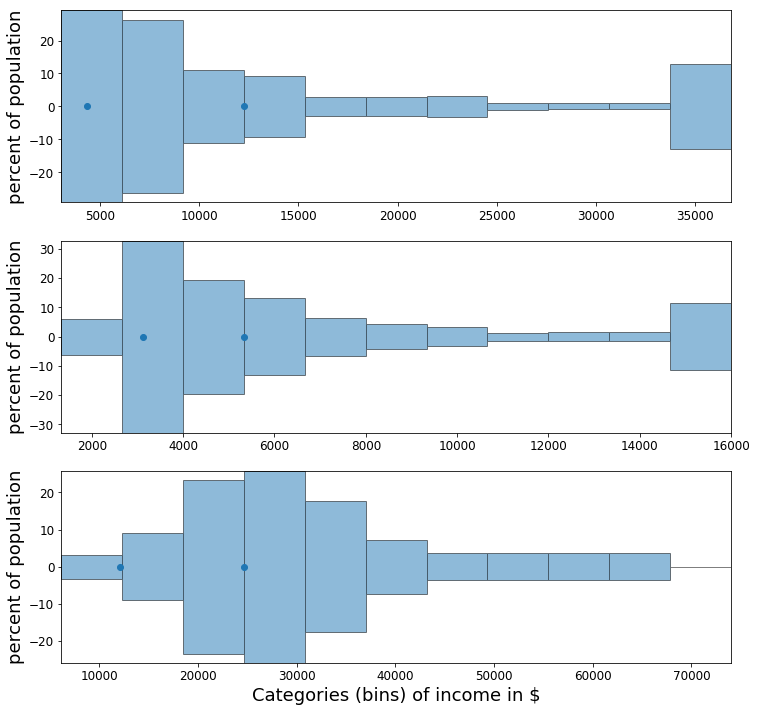

In [33]:
%matplotlib inline
# fig, ax = plt.subplots()

def demo_plot_income_dist(ax, patch):
    ax.add_patch(patch['patch'])
    ax.set_xlim(patch['xlim'])
    ax.set_ylim(patch['ylim'])
    #ax.set_xlabel("Categories (bins) of income in $")
    ax.set_ylabel("percent of population")

fig = plt.figure(figsize=(12,9))
#(ax1, ax2, ax3) = fig.add_subplot(3, 1, 1)
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,12))
pnum = len(test_countries)
fig, ax = plt.subplots(pnum, figsize=(12,12))

for pos in range(pnum):
    patch = create_patch__from__income_dist(testi[pos], rescale=False)
    demo_plot_income_dist(ax[pos], patch)
    ax[pos].plot([ testi[pos]['Median GDP per capita'], testi[pos]['GDP per capita'] ], [0,0], 'o')
ax[pnum-1].set_xlabel("Categories (bins) of income in $")

plt.show()

In [34]:
def bubble_plot(ax, b_df, x_name = 'GDP per capita'):
    X = b_df[x_name] / 1000
    Y = b_df.loc[ : , b_df.columns.isin( ['Life expectancy'] ) ]#.sort_index(axis=1).T # Select relative income distribution
    population = b_df.loc[ : , b_df.columns.isin( ['Total population'] ) ]
    if b_df.columns.isin( ['Country'] ).any()==False:
        countries = b_df.index.to_series()
        #print(countries)
    else:
        countries = b_df.loc[ : , b_df.columns.isin( ['Country'] ) ]
    radius_max = 100
    radius_min = 2
    radius = (radius_max * population / population.max()).clip(lower=5)
        
    area = np.pi * ( radius )**2
    
    N = X.count()
    
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(40, 95, 5)
    minor_ticks = np.arange(40, 95, 1)
    
    ax.plot(X,Y,'o')


    for pos in range(N):# zip(countries, Y):                                       # <--
        #print(xy)
        print(countries.iloc[pos])
        ax.annotate(countries.iloc[pos], xy=(X.iloc[pos],Y.iloc[pos]),\
                    textcoords='data', horizontalalignment='center', verticalalignment='center') # <--
    ax.set_xlabel(x_name + "[K$]")
    ax.set_ylabel('Life expectancy [years]')
    #plt.show()
    

def income_plot(ax, b_df, x_name = 'GDP per capita', scale_adjustment=1.0):
    X = b_df[x_name]# / 1000
    Y = b_df.loc[ : , b_df.columns.isin( ['Life expectancy'] ) ]#.sort_index(axis=1).T # Select relative income distribution
    population = b_df.loc[ : , b_df.columns.isin( ['Total population'] ) ]
    if b_df.columns.isin( ['Country'] ).any()==False:
        countries = b_df.index.to_series()
        #print(countries)
    else:
        countries = b_df.loc[ : , b_df.columns.isin( ['Country'] ) ]
    radius_max = 100
    radius_min = 2
    radius = (radius_max * population / population.max()).clip(lower=5)
        
    area = np.pi * ( radius )**2
    
    N = X.count()
    #x = np.random.rand(N)
    #y = np.random.rand(N)
    colors = np.random.rand(N)
    #area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii
    
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(40, 95, 5)
    minor_ticks = np.arange(40, 95, 1)
    
    #ax.set_ylim((40,90))



    for pos in range(N):
        #print(xy)
        #print(countries.iloc[pos])
        patch = create_patch__from__income_dist(b_df.iloc[pos], x_name=x_name, scale_adjustment=scale_adjustment)
        ax.add_patch(patch['patch'])
        
        (x_min,x_max) = patch['xlim']
        ax.annotate(countries.iloc[pos], xy=(x_min,Y.iloc[pos]),\
                    textcoords='data', horizontalalignment='right', verticalalignment='center') # <--
    ax.set_xlabel(x_name + "[$]")
    ax.set_ylabel('Life expectancy [years]')
    #plt.show()
    

### Extending the Gapminder World by the income distribution within a country
This modified illustration of the *Gapminder World* is replacing the bubbles through shapes of the income distribution inside the countries.

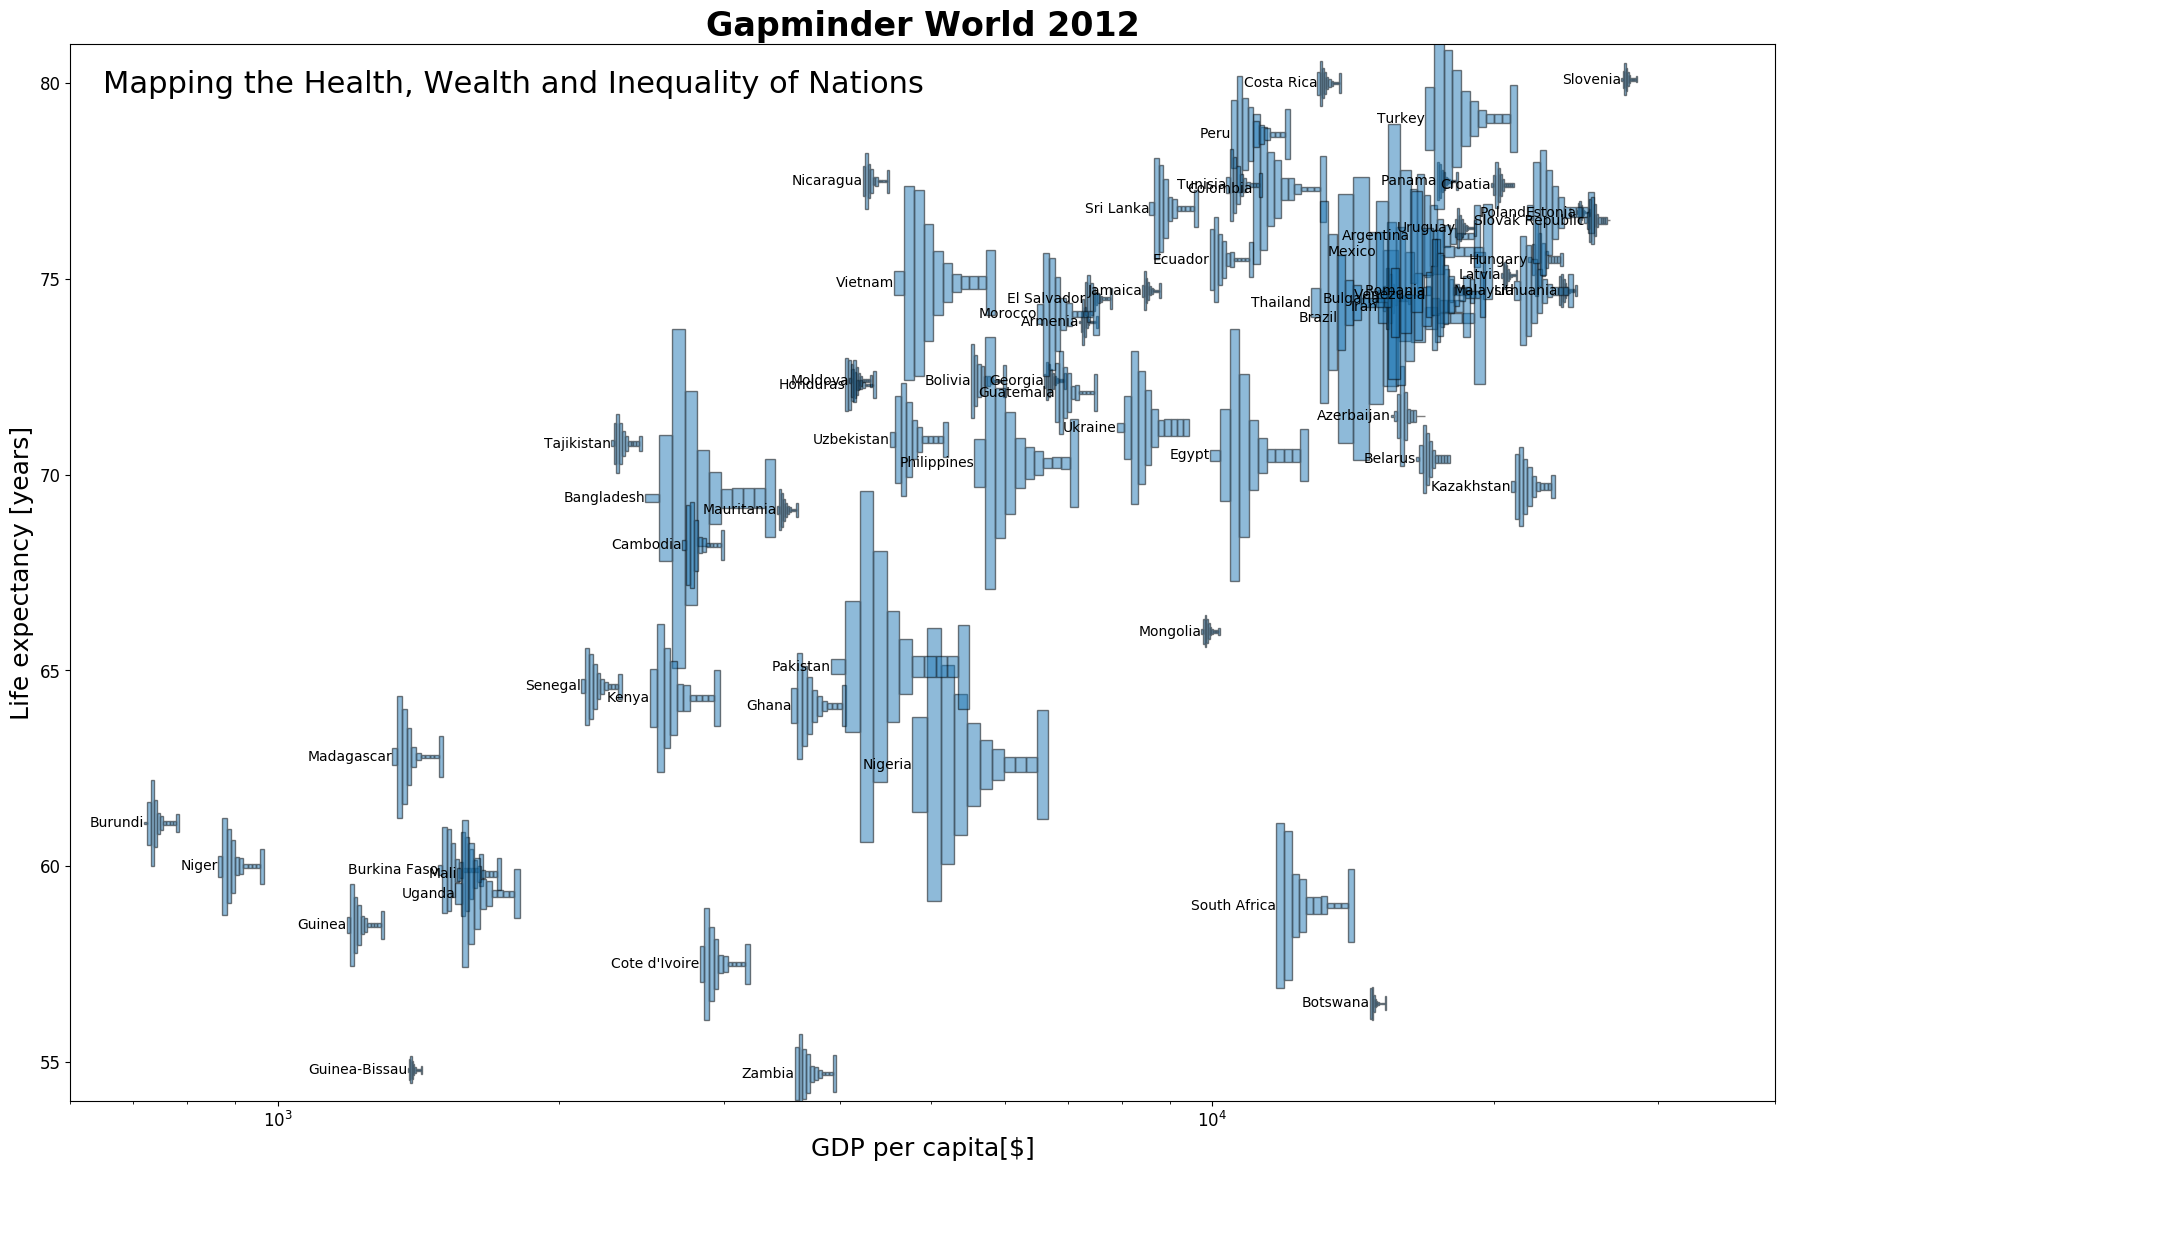

In [88]:
%matplotlib inline
jahr = 2012.0
df = indica_all_interp.applymap(lambda x: x(jahr))
x_n = 'GDP per capita'
#ax=plt.subplots(figsize=fs, dpi=dpi)
fig = plt.figure(figsize=(22,14), dpi=100)
# fig.suptitle('bold figure suptitle', fontsize=24, fontweight='bold')
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.set_xlim((600, 40000))
ax.set_ylim((54,81))
ax.set_title('Gapminder World {0:.0f}'.format(jahr),fontsize=24, fontweight='bold')
ax.text(650, 79.75, 'Mapping the Health, Wealth and Inequality of Nations', fontsize=22)
#bubble_plot(ax,df,x_name = x_n)
income_plot(ax,df,x_name = x_n, scale_adjustment=1.0)
plt.show()

*Note: I am aware the font size is inappropriately small. This might be due to an [issue](https://github.com/matplotlib/matplotlib/issues/9217) with *matplotlob* and *Jupyer Notebook* about setting the fig size conveniently. Didn't find a proper workaround yet.*

However, this illustration is a little bit to packed. Therefore the countries are now grouped by different categories (bins) of *GDP per capita*, while introducing an animation over time...

### Animating the Gapminder World
The time series data is used to redo the *Gapminder World* animation within the period of time, constrained by the availability of data on *Income share held by...*

In [79]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


def make_income_clip(selected_xlim, selected_ylim=(40,90), scale_adjustment=1.0):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(1, 1, 1)
    
    def animate(i):
        ax.clear()
        (xmin, xmax) = selected_xlim
        ax.set_xlim((xmin, xmax))
        ax.set_ylim(selected_ylim)
        year = 1978.0 + t[i]
        # ax.set_title('Income distribution, GDP and life expectancy in {0:.2f}.'.format(year),fontsize=22)
        ax.set_title('Gapminder World {0:.2f}'.format(year),fontsize=24, fontweight='bold')
        # ax.text(650, 79.75, 'Mapping the Health, Wealth and Inequality of Nations', fontsize=22)
        df = indica_all_interp.applymap(lambda x: x( year ))
        x_n = 'GDP per capita' # This should be the 'Median GDP per capita' instead
        myfilter = (df[x_n] > (xmin-1000)) & (df[x_n] < (xmax+2000))
        dff = df[myfilter]
        income_plot(ax,dff, x_name = x_n, scale_adjustment=scale_adjustment)

    t = np.linspace(0, 32, 180)
    
    anim = FuncAnimation(fig, animate, interval=100, frames=len(t)-1, repeat=True)
    return anim

#### Group 1: Least developed countries

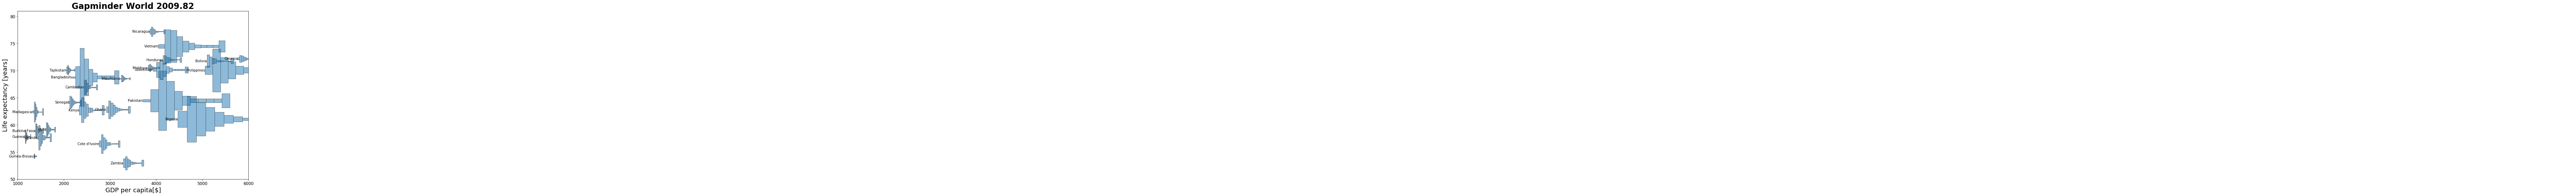

In [80]:
selected_xlim = (1001,6000)
HTML(make_income_clip(selected_xlim, selected_ylim=(50,81), scale_adjustment=1.25).to_html5_video())

#### Group 2: Economies in transition

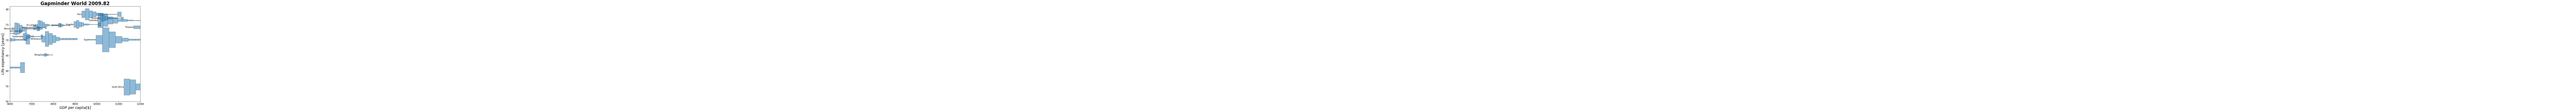

In [89]:
selected_xlim = (6000,12000)
HTML(make_income_clip(selected_xlim, selected_ylim=(50,81), scale_adjustment=1.25).to_html5_video())

#### Group 3: Developed economies

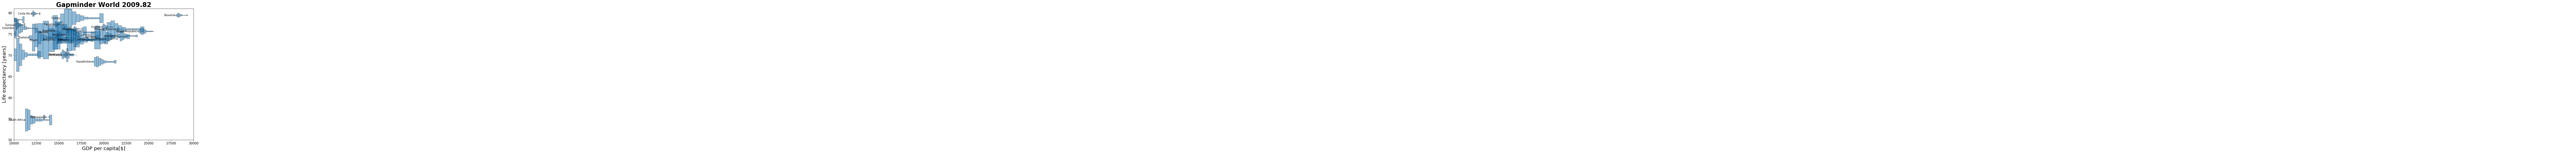

In [91]:
selected_xlim = (10000,30000)
HTML(make_income_clip(selected_xlim, selected_ylim=(50,81), scale_adjustment=1.25).to_html5_video())

<a id='conclusions'></a>
## Conclusions

- An extended approach is shown to illustrate the health and wealth of the world without disregarding the inequality within the countries.
- Inequality is present to a very different extend inside the countries of the world.
- There is a correlation between extreme inequality and health of the nations, e.g. for South Africa and Botswana. On the other hand, there are no examples of nations with a high inequality and a good life expectancy.
- Some nations seem to have very healthy people although their *GDP per capita* is low. For example Nicaragua, Peru and Costa Rica.
- Certainly many more indicators correlate with the life expectancy, which were not investigated within this work.
- Unfortunately no data is available on the life expectancy of the health of people with different income within a country